In [11]:

import os
import numpy as np
import matplotlib.pyplot as plt # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_data = train_datagen.flow_from_directory(
    'dataset/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    'dataset/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4658 images belonging to 6 classes.
Found 1994 images belonging to 6 classes.


In [13]:
print(train_data.class_indices)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2, 'Tomato___Early_blight': 3, 'Tomato___Late_blight': 4, 'Tomato___healthy': 5}


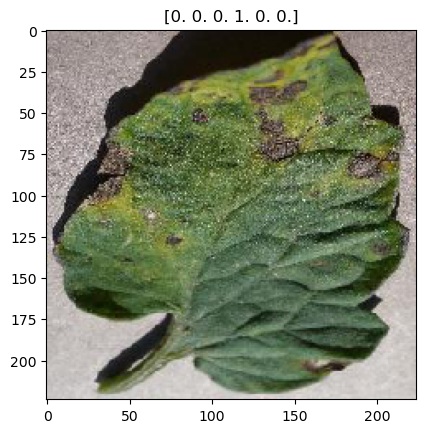

In [14]:
for image_batch, label_batch in train_data:
    plt.imshow(image_batch[0])
    plt.title(label_batch[0])
    plt.show()
    break



In [15]:
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # type: ignore

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [17]:

from tensorflow.keras.optimizers import Adam # type: ignore
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    verbose=1
)

Epoch 1/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.6522 - loss: 0.9581 - val_accuracy: 0.8526 - val_loss: 0.4789
Epoch 2/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.8295 - loss: 0.4784 - val_accuracy: 0.8932 - val_loss: 0.3246
Epoch 3/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.8796 - loss: 0.3490 - val_accuracy: 0.9072 - val_loss: 0.2690
Epoch 4/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9000 - loss: 0.2853 - val_accuracy: 0.9268 - val_loss: 0.2275
Epoch 5/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9150 - loss: 0.2431 - val_accuracy: 0.9288 - val_loss: 0.2067
Epoch 6/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 70s 478ms/step - accuracy: 0.9309 - loss: 0.2153 - val_accuracy: 0.9313 - val_loss: 0.1912
Epoch 7/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.9322 - loss: 0.1983 - val_accuracy: 0.9393 - val_loss: 0.1759
Epoch 8/15
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 300ms/step - accuracy: 0.9418 - loss: 0

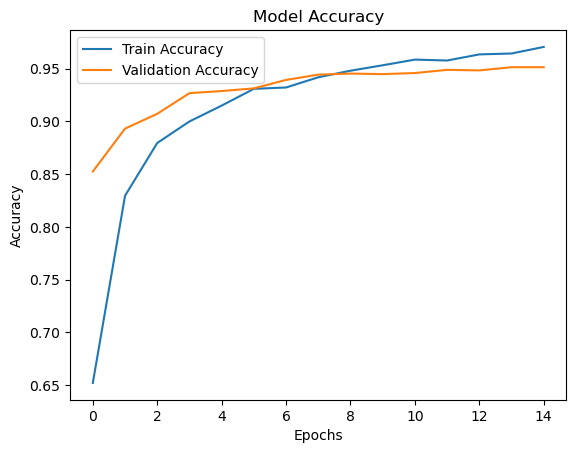

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [20]:

model.save('model.h5')

In [21]:
for layer in base_model.layers[-20:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=5)


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 58s 382ms/step - accuracy: 0.8912 - loss: 0.2902 - val_accuracy: 0.9448 - val_loss: 0.1519
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 55s 378ms/step - accuracy: 0.9375 - loss: 0.1861 - val_accuracy: 0.9468 - val_loss: 0.1401
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 55s 375ms/step - accuracy: 0.9485 - loss: 0.1486 - val_accuracy: 0.9519 - val_loss: 0.1314
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 54s 373ms/step - accuracy: 0.9635 - loss: 0.1169 - val_accuracy: 0.9559 - val_loss: 0.1258
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 54s 373ms/step - accuracy: 0.9702 - loss: 0.0950 - val_accuracy: 0.9559 - val_loss: 0.1237


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

val_data.reset()

y_pred_prob = model.predict(val_data)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step


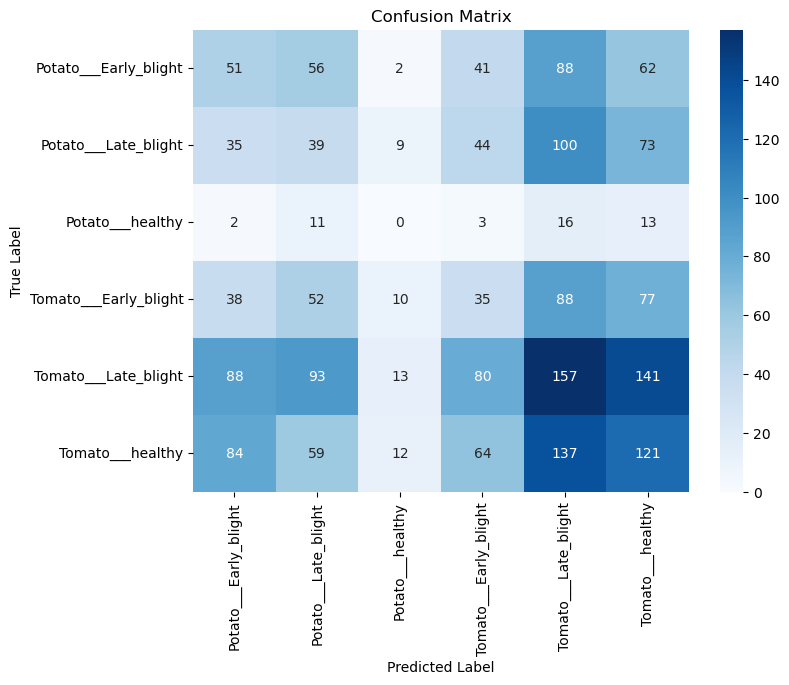

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap( # type: ignore
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=val_data.class_indices.keys(),
    yticklabels=val_data.class_indices.keys()
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [24]:
print(classification_report(
    y_true,
    y_pred,
    target_names=val_data.class_indices.keys()
))


                       precision    recall  f1-score   support

Potato___Early_blight       0.17      0.17      0.17       300
 Potato___Late_blight       0.13      0.13      0.13       300
     Potato___healthy       0.00      0.00      0.00        45
Tomato___Early_blight       0.13      0.12      0.12       300
 Tomato___Late_blight       0.27      0.27      0.27       572
     Tomato___healthy       0.25      0.25      0.25       477

             accuracy                           0.20      1994
            macro avg       0.16      0.16      0.16      1994
         weighted avg       0.20      0.20      0.20      1994

